# Investment Strategies
Create investment strategies to beat the benchmark.

### Product:
    FTSE 100 ETF - ISF

### Limit:
    £20,000 per year

### Goal:
    Buy as many shares as possible

In [17]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go

import utils

import plotly.io as pio
pio.renderers.default = "png"


In [18]:
BASE_URL = 'https://docs.google.com/spreadsheets/d/10cihRP6XxJOSrWsASfW5C7VeHufD32TS0JKCXLoWhL8/export?format=csv&{}'

UKX_sheet = BASE_URL.format('gid=134530274')

ISF_sheet = BASE_URL.format('gid=1374752918')


In [19]:
# Read data
df = pd.read_csv(ISF_sheet)

# Rename columns
df = df.rename(columns={'Unnamed: 1': 'Open'})

# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'].str[:10], format="%d/%m/%Y")

# Get datetime related fields
df['month'] = df['Date'].dt.month_name()
df['year'] = df['Date'].dt.year
df['day'] = df['Date'].dt.day
df['day_name'] = df['Date'].dt.day_name()
df['weekofyear'] = df['Date'].dt.weekofyear
df['is_quarter_end'] = df['Date'].dt.is_quarter_end
df['is_quarter_start'] = df['Date'].dt.is_quarter_start
df['quarter'] = df['Date'].dt.quarter
df['avg'] = round((df['High'] + df['Low']) / 2, 2) # $\frac{high + low}{2}$

# df = df.set_index('Date')

In [20]:
LIMIT = 2000000 # £20,000 per year
FEE = 995

## Strategy 1 - Pound Cost Averaging, first monday of every month
- This serves as the benchmark

In [21]:
monthly_limit = (LIMIT/12) - FEE

strategy_1 = (
        monthly_limit/(df
            .loc[
                df['Date'].isin(
                    df
                    .loc[(df['day_name'] == 'Monday') & (df['year'] < 2020), ['Date', 'year', 'month']]
                    .groupby(['year', 'month'])
                    .agg({'Date': min})
                    .reset_index()
                    .loc[:, 'Date']
                    .to_list()
                    ), 
                ['Date', 'avg']
            ]
        )    
        .set_index('Date')
    )

strategy_1 = strategy_1.reset_index()
strategy_1 = strategy_1.groupby(strategy_1['Date'].dt.year).sum().rename(columns={'avg': 'shares'})


In [22]:
strategy_1.tail(3)

,shares
Date,
2017,2718.113402
2018,2698.566427
2019,2783.042830


### Strategy Performance

In [23]:
tmp = strategy_1.copy()

mean_price = df.loc[(df['year']==2020) & (df['month']=='January'), 'avg'].mean()

total_shares = tmp['shares'].sum()
amount_invested = int((LIMIT * tmp.shape[0])/100)

value = int((total_shares * mean_price)/100)
profit = value - amount_invested
value_increase = round((profit/amount_invested)*100, 2)

print('Total no. of Shares:', int(total_shares))
print('Amount invested: £{:,}'.format(amount_invested))
print('Total value of Shares in Jan 2020: £{:,}'.format(value))
print('Total profit in {} years: £{:,}'.format(tmp.shape[0], profit))
print('Total value increased: {}%'.format(value_increase))

Total no. of Shares: 68519
Amount invested: £400,000
Total value of Shares in Jan 2020: £510,861
Total profit in 20 years: £110,861
Total value increased: 27.72%


## Strategy 2 (test) - Invest once a year on first monday of April (arbitrary date)
- We'll be using the average price to buy shares

In [24]:
yearly_limit = LIMIT - FEE

strategy_2 = (
    (yearly_limit/(df
        .loc[
            df['Date'].isin(
                df
                .loc[(df['month'] == 'August') & (df['day_name'] == 'Monday'), ['Date', 'year', 'month']]
                .groupby(['year', 'month'])
                .agg({'Date': min})
                .reset_index()
                .loc[:, 'Date']
                .to_list()
                ), 
            ['Date', 'avg']
            ]
        .set_index('Date')
        )
    )
    .rename(columns={'avg': 'shares'})
)


In [25]:
strategy_2.tail(3)

,shares
Date,
2017-08-07,2679.739132
2018-08-06,2633.908690
2019-08-05,2781.495241


### Strategy Performance

In [28]:
tmp = strategy_2.copy()

mean_price = df.loc[(df['year'] == 2020) & (df['month'] == 'January'), 'avg'].mean()

total_shares = tmp['shares'].sum()
amount_invested = int((LIMIT * tmp.shape[0])/100)

value = int((total_shares * mean_price)/100)
profit = value - amount_invested
value_increase = round((profit/amount_invested)*100, 2)

print('Total no. of Shares:', int(total_shares))
print('Amount invested: £{:,}'.format(amount_invested))
print('Total value of Shares in Jan 2020: £{:,}'.format(value))
print('Total profit in {} years: £{:,}'.format(tmp.shape[0], profit))
print('Total value increased: {}%'.format(value_increase))

Total no. of Shares: 70237
Amount invested: £400,000
Total value of Shares in Jan 2020: £523,665
Total profit in 20 years: £123,665
Total value increased: 30.92%


## Strategies Performance Plots

In [29]:
result = pd.DataFrame(index=pd.date_range(start='2000-12-31', end='2019-12-31', freq='Y'))

result['strategy_1'] = strategy_1['shares'].to_list()
result['strategy_2'] = strategy_2['shares'].to_list()

result.tail(3)

,strategy_1,strategy_2
2017-12-31,2718.113402,2679.739132
2018-12-31,2698.566427,2633.908690
2019-12-31,2783.042830,2781.495241


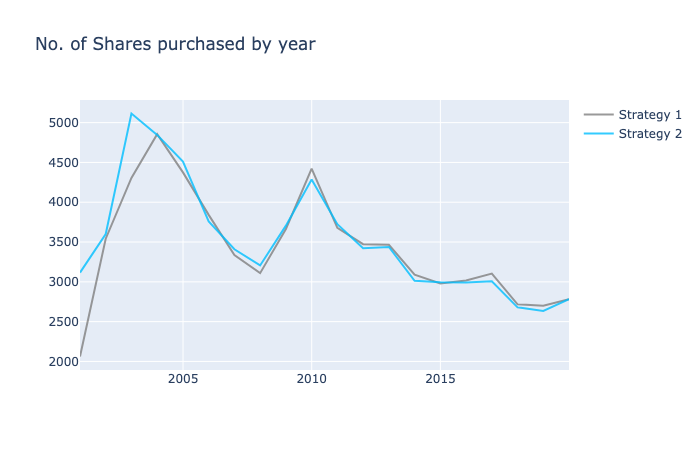

In [30]:
# df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv")

fig = go.Figure()

fig.add_trace(go.Scatter(
                x=result.index,
                y=result['strategy_1'],
                name="Strategy 1",
                line_color='grey',
                opacity=0.8)
             )

fig.add_trace(go.Scatter(
                x=result.index,
                y=result['strategy_2'],
                name="Strategy 2",
                line_color='deepskyblue',
                opacity=0.8)
             )


# Use date string to set xaxis range
fig.update_layout(
    title_text="No. of Shares purchased by year",
    # xaxis_range=['2016-07-01','2016-12-31'],
)


fig.show()

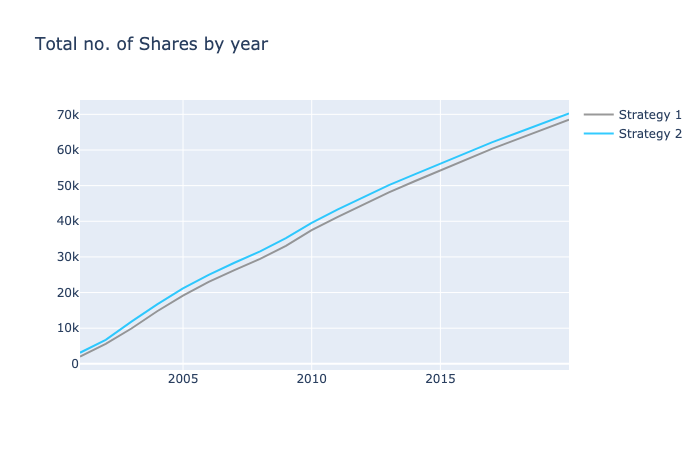

In [31]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                x=result.index,
                y=result['strategy_1'].cumsum(),
                name="Strategy 1",
                line_color='grey',
                opacity=0.8)
             )

fig.add_trace(go.Scatter(
                x=result.index,
                y=result['strategy_2'].cumsum(),
                name="Strategy 2",
                line_color='deepskyblue',
                opacity=0.8)
             )


# Use date string to set xaxis range
fig.update_layout(
    title_text="Total no. of Shares by year",
    # xaxis_range=['2016-07-01','2016-12-31'],
)


fig.show()